In [7]:
import torch
print(torch.__version__)
#import torchvision
#import torch.nn as nn

import os
#matplotlib.use('Agg')
%matplotlib inline

from data_loader import get_train_val_loader, get_test_loader
from autoencoder_helpers import *
from modules import *
from model_testing import *
from sklearn.decomposition import PCA
from PIL import Image
import re

#GPU/CUDA setup
if torch.cuda.is_available():
    print("CUDA enabled!")
    device = torch.device('cuda:0')  # You can specify the index of the CUDA device you want to use
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Specify the index of the GPU(s) you want to use
else:
    print("CUDA not available. Using CPU.")
    device = torch.device('cpu')

input_height = 28         # MNIST data input shape
input_width = input_height
  
data_folder = 'data'
batch_size = 250
n_workers = 0
random_seed = 0

# download MNIST data
test_loader = get_test_loader(data_folder, batch_size, shuffle=True, num_workers=n_workers, pin_memory=True)

# download MNIST data
train_loader, val_loader = get_train_val_loader(data_folder, batch_size, random_seed, augment=False, val_size=0.2,
                           shuffle=True, show_sample=False, num_workers=0, pin_memory=True)

2.2.0
CUDA enabled!


In [9]:
#Paths to saved models
paths = {"B30": "saved_model\mnist_model\mnist_cae_balanced_clstsep_1500_0.002_250_True_0.0_20_1_1_1_1.0_0.0_30_4_32_1",
         "S30": "saved_model\mnist_model\mnist_cae_standard_default_1500_0.002_250_False_0.5_20_1_1_1_0.8_0.2_30_4_32_1",
         "S15": "saved_model\mnist_model\mnist_cae_standard_default_1500_0.002_250_False_0.5_20_1_1_1_0.8_0.2_15_4_32_1",
         "RS30": "saved_model\mnist_model\mnist_cae_adversarial_standard_default_pdglinf_ce_20_0.3_0.02_True_1500_0.002_250_False_0.5_20_1_1_1_0.8_0.2_1.0_30_4_32_1",
         "RB30": "saved_model\mnist_model\mnist_cae_adversarial_balanced_clstsep_pdglinf_ce_20_0.3_0.02_True_800_0.002_250_True_0.0_20_1_1_1_1.0_0.0_1.0_30_4_32_1",
         "FTB30n": "saved_model\mnist_model\mnist_cae_FT_30_nothing_pdglinf_ce_20_0.3_0.02_True_20_0.002_250_20_1_1_1_1.0_0.0_1",
         "FTB30a": "saved_model\mnist_model\mnist_cae_FT_30_autoencoder_pdglinf_ce_20_0.3_0.02_True_20_0.002_250_20_1_1_1_1.0_0.0_1",
         "FTB30p": "saved_model\mnist_model\mnist_cae_FT_30_prototypes_pdglinf_ce_20_0.3_0.02_True_20_0.002_250_20_1_1_1_1.0_0.0_1"}

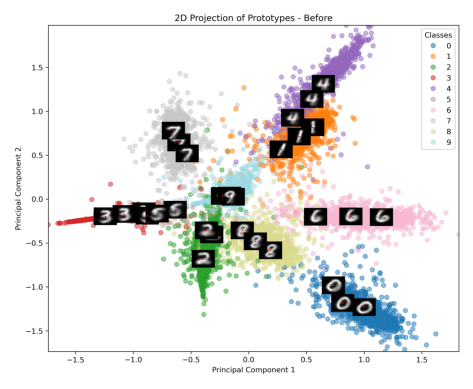

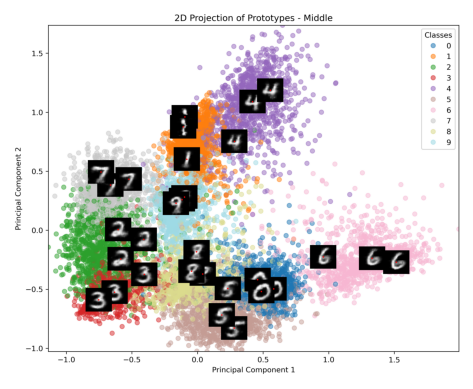

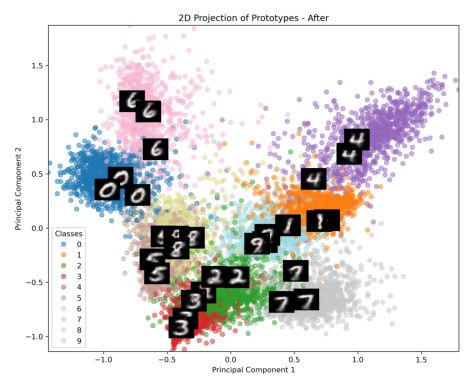

In [10]:
# Path to the directory containing model files
directory_path = paths["FTB30n"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of specific model files to process
specific_models = ["mnist_cae_adv00000.pth", "mnist_cae_adv00010.pth", "mnist_cae_adv00020.pth"]

# Plot and save the images for the specific models
for idx, model_file in enumerate(specific_models):
    model_path = os.path.join(directory_path, model_file)
    
    # Load the model and fit PCA to the test data
    model = torch.load(model_path)
    model.to(device)
    model.eval()
    reduced_test_data, test_labels, pca = get_encoded_test_data_and_fit_pca(test_loader, model, device)
    
    # Project the prototypes using the PCA fitted on test data
    reduced_prototypes, prototype_imgs = get_prototype_projection(model_path, device, pca)
    
    # Calculate the x and y limits for the current model's data
    xlim = (min(reduced_test_data[:, 0].min(), reduced_prototypes[:, 0].min()), max(reduced_test_data[:, 0].max(), reduced_prototypes[:, 0].max()))
    ylim = (min(reduced_test_data[:, 1].min(), reduced_prototypes[:, 1].min()), max(reduced_test_data[:, 1].max(), reduced_prototypes[:, 1].max()))
    
    if idx == 0:
        title = '2D Projection of Prototypes - Before'
    elif idx == len(specific_models) - 1:
        title = '2D Projection of Prototypes - After'
    else:
        title = '2D Projection of Prototypes - Middle'
    
    save_path = os.path.join(directory_path, f'{model_file}_projection.png')
    plot_prototype_projection_with_data(reduced_prototypes, prototype_imgs, reduced_test_data, test_labels, title, xlim, ylim, save_path)
    
    image = plt.imread(save_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()